In [11]:
# # Comparative study of data preparation methods in quantum 
#                       clustering algorithms
#                                 by
#
# Alekha Bhatt, Chetan Dandin and Sri Vallabha Vaidya
#
# This code is used to evaluate the Classical K Means Clustering algorithm 
#
# References
# https://github.com/CQCL/qiskit-tutorial/blob/master/community/awards/teach_me_qiskit_2018/quantum_machine_learning/1_K_Means/Quantum%20K-Means%20Algorithm.ipynb
# https://github.com/smit14/Quantum-K-means-algorithm/blob/master/k_means_quantum.ipynb
#
##########################################################################

In [56]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time

# Import specific modules from scikit-learn
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score

# The code imports commonly used libraries and modules for data analysis, visualization, and machine learning tasks.
# - numpy (as np) is used for numerical operations.
# - matplotlib.pyplot (as plt) is used for data visualization.
# - math provides mathematical functions and constants.
# - pandas (as pd) is used for data manipulation and analysis.
# - time is used to measure execution time of certain parts of the code.

# The code then imports specific modules from scikit-learn (sklearn), a popular machine learning library in Python.
# - load_iris, load_wine, and load_breast_cancer are functions to load sample datasets from scikit-learn.
# - PCA is used for principal component analysis, a dimensionality reduction technique.
# - MinMaxScaler is used for scaling features to range 0 to 1.
# - davies_bouldin_score and silhouette_score are used for cluster evaluation metrics.

In [57]:
# Define the function 'get_data' with two input parameters: k and model
def get_data(k, model):
    # Check the value of the 'model' parameter to determine which dataset to use
    # If 'model' is "iris", load the iris dataset
    if model == "iris":
        data1 = load_iris()
    # If 'model' is "wine", load the wine dataset
    elif model == "wine":
        data1 = load_wine()
    # If 'model' is neither "iris" nor "wine", load the breast cancer dataset
    else:
        data1 = load_breast_cancer()
    
    # Create a DataFrame 'df' from the loaded dataset, using the data and feature names
    df = pd.DataFrame(data1['data'], columns=data1['feature_names'])
    
    # Perform Principal Component Analysis (PCA) with 2 components
    pca_1 = PCA(n_components=2)
    pca_1.fit(df)
    
    # Transform the data to 2-dimensional points using PCA
    points = pca_1.transform(df)
    
    # Return the transformed points as the result
    return points

In [58]:
# Define the function 'draw_plot' with three input parameters: points, centers, and label
def draw_plot(points, centers, label=True):
    # Check the value of the 'label' parameter
    # If 'label' is False, plot the points without centers
    
    if label == False:
        plt.scatter(points[:, 0], points[:, 1], s=3)
        
    # If 'label' is True, plot the points with different colors according to their centers
    else:
        for cluster_id in np.unique(centers):
            cluster_data = points[centers == cluster_id]
            #assigning labels to each cluster to display legends in the scatter plot
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {int(cluster_id) + 1}', s=3)
        plt.legend(loc='lower right', fontsize=6) #display the legends on the lower right side of the scatter plot

        
    # Set the limits of the x-axis and y-axis for the plot
    plt.xlim(-0.15, 1.2)
    plt.ylim(-0.15, 1.2)
    
    # Show the plot
    plt.show()

In [59]:
# Define the function 'plot_centroids' with one input parameter: centers
def plot_centroids(centers):
    # Scatter plot the centroids using the x-coordinates from the first column (centers[:,0]) 
    # and y-coordinates from the second column (centers[:,1]) of the 'centers' array.
    # The 's=3' parameter sets the size of the plotted points to 3.
    plt.scatter(centers[:, 0], centers[:, 1], s=3)
    
    # Set the limits of the x-axis and y-axis for the plot to ensure all centroids are visible.
    plt.xlim(-0.15, 1.2)
    plt.ylim(-0.15, 1.2)
    
    # Show the plot with the centroids.
    plt.show()

In [60]:
# Defining the function 'initialize_centers' with two input parameters: points and k
def initialize_centers(points, k):
    # Set a random seed (seed=45) for reproducibility of random number generation
    np.random.seed(45)
    
    # Use NumPy's random.randint function to randomly select 'k' points (row indices) from the 'points' array.
    # The random integers will be in the range [0, points.shape[0]), where points.shape[0] gives the number of rows in the 'points' array.
    # This means the indices will be in the range [0, points.shape[0]-1].
    # The function returns 'k' randomly chosen rows from the 'points' array as the initial centers.
    return points[np.random.randint(points.shape[0], size=k), :]

In [61]:
def get_distance(p1, p2):
    #calculating Euclidean distance between 2 points
    return np.sqrt(np.sum((p1-p2)*(p1-p2)))

In [62]:
# Define the function 'find_nearest_neighbour' with three input parameters: points, centroids, and count1
def find_nearest_neighbour(points, centroids):
    # Get the number of data points (n) and the number of centroids (k)
    n = len(points)
    k = centroids.shape[0]
    
    # Create an array 'centers' of zeros with the same length as 'points'
    centers = np.zeros(n)
    
    # Loop through each data point in 'points'
    for i in range(n):
        # Initialize 'min_dis' to a large value (10000) to find the minimum distance
        min_dis = 10000
        # Initialize 'index' to 0 to track the index of the nearest centroid
        index = 0
        
        # Loop through each centroid in 'centroids'
        for j in range(k):
            # Calculate the distance between the current data point (points[i,:]) and the current centroid (centroids[j,:])
            temp_dist = get_distance(points[i, :], centroids[j, :])
                        
            # Check if the calculated distance is smaller than the current minimum distance
            if temp_dist < min_dis:
                # If true, update the minimum distance and the index of the nearest centroid
                min_dis = temp_dist
                index = j
        
        # Assign the index of the nearest centroid to the 'centers' array for the current data point
        centers[i] = index
    
    # Return the 'centers' array, which contains the index of the nearest centroid for each data point
    return centers

In [63]:
# Define the function 'find_centroids' with two input parameters: points and centers
def find_centroids(points, centers):
    # Get the number of data points (n) and the number of clusters (k)
    n = len(points)
    k = int(np.max(centers)) + 1
    
    # Create an array 'centroids' of zeros with dimensions (k, 2)
    centroids = np.zeros([k, 2])
    
    # Loop through each cluster (indexed from 0 to k-1)
    for i in range(k):
        # Calculate the mean (average) of the data points belonging to the current cluster
        # 'points[centers==i]' selects the data points where 'centers' has the value 'i' (current cluster index)
        # np.average() calculates the mean of the selected data points along each dimension (x and y)
        centroids[i, :] = np.average(points[centers == i], axis=0)
    
    # Return the calculated centroids
    return centroids

In [64]:
# Define the function 'preprocess' with one input parameter: points
def preprocess(points):
    # Create an instance of MinMaxScaler, which will scale the data to the range [0, 1]
    scaler = MinMaxScaler()
    
    # Use the 'fit_transform' method of MinMaxScaler to normalize the data points
    # The 'fit_transform' method computes the minimum and maximum values of each feature in 'points'
    # and scales the data points accordingly to the range [0, 1].
    normalized_data = scaler.fit_transform(points)
    
    # Return the normalized data points
    return normalized_data

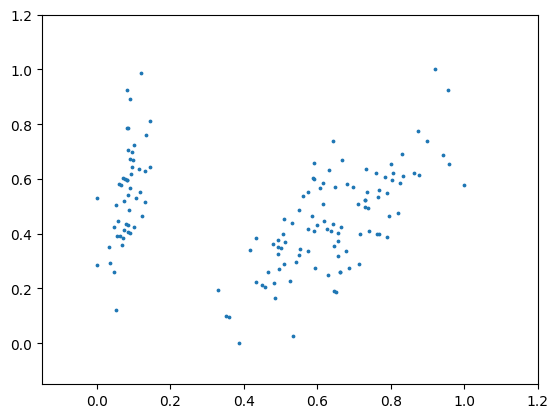

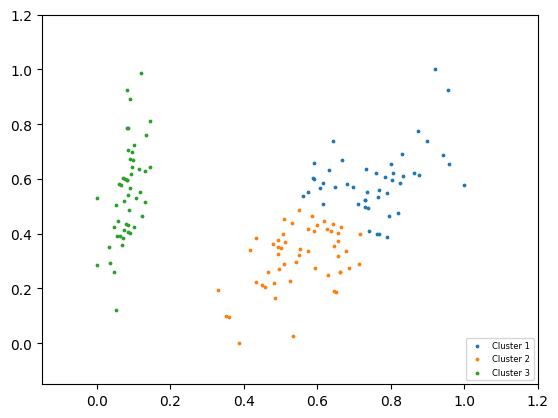

Davies-Bouldin Index: 0.6821056015111436
Silhouette Score: 0.5194151091299876
Execution time:  1.2523744106292725


In [53]:
# Set the number of centers (k), dataset model ("iris" in this case)
k = 3
model = "iris"

# Get the data points using the specified model ("iris")
points = get_data(k, model)

# Preprocess (normalize) the data points using Min-Max scaling
points = preprocess(points)

# Initialize the centroids for the k-means algorithm
centroids = initialize_centers(points, k)

# Plot the initial data points without centers (label=False)
plt.figure()
draw_plot(points, centroids, label=False)

# Run the k-means algorithm for a fixed number of iterations (50 in this case)
start_time = time.time()
for i in range(300):
    # Find the nearest centers for each data point using the current centroids
    centers = find_nearest_neighbour(points, centroids)
    
    # Plot the data points with centers after each iteration
    plt.figure()
    draw_plot(points, centers)
    
    # Update the centroids based on the mean of the data points belonging to each cluster
    centroids = find_centroids(points, centers)

end_time = time.time()

# Calculate the Davies-Bouldin Index to evaluate the clustering quality
db_index = davies_bouldin_score(points, centers)
print('Davies-Bouldin Index:', db_index)

# Calculate the Silhouette Score to evaluate the clustering quality
silhoutte_score = silhouette_score(points, centers)
print('Silhouette Score:', silhoutte_score)

# Calculate the execution time of the k-means algorithm
exec_time = end_time - start_time
print("Execution time: ", exec_time)


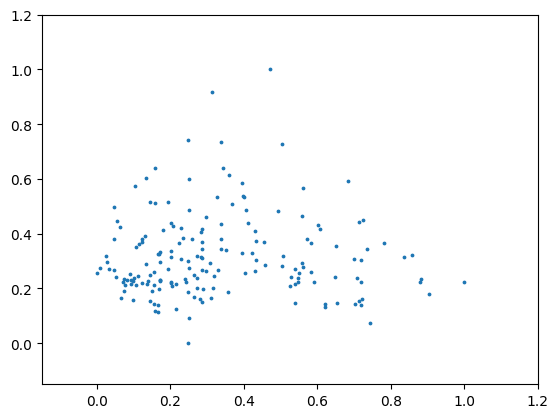

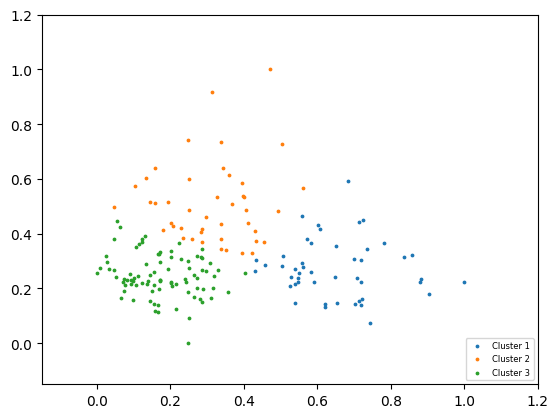

Davies-Bouldin Index: 0.8634366759763724
Silhouette Score: 0.453395519640296
Execution time:  0.22165942192077637


In [54]:
# Set the number of centers (k), dataset model ("wine" in this case), and count1 (used to print Quantum circuit in get_Distance())
k = 3
model = "wine"

# Get the data points using the specified model ("wine")
points = get_data(k, model)

# Preprocess (normalize) the data points using Min-Max scaling
points = preprocess(points)

# Initialize the centroids for the k-means algorithm
centroids = initialize_centers(points, k)

# Plot the initial data points without centers (label=False)
plt.figure()
draw_plot(points, centroids, label=False)

# Run the k-means algorithm for 2 iterations
start_time = time.time()
for i in range(50):
    # Find the nearest centers for each data point using the current centroids
    centers = find_nearest_neighbour(points, centroids)
    
    # Plot the data points with centers after each iteration
    plt.figure()
    draw_plot(points, centers)
    
    # Update the centroids based on the mean of the data points belonging to each cluster
    centroids = find_centroids(points, centers)


end_time = time.time()

# Calculate the Davies-Bouldin Index to evaluate the clustering quality
db_index = davies_bouldin_score(points, centers)
print('Davies-Bouldin Index:', db_index)

# Calculate the Silhouette Score to evaluate the clustering quality
silhouette_score = silhouette_score(points, centers)
print('Silhouette Score:', silhouette_score)

# Calculate the execution time of the k-means algorithm in minutes
exec_time = end_time - start_time
print("Execution time: ", exec_time)

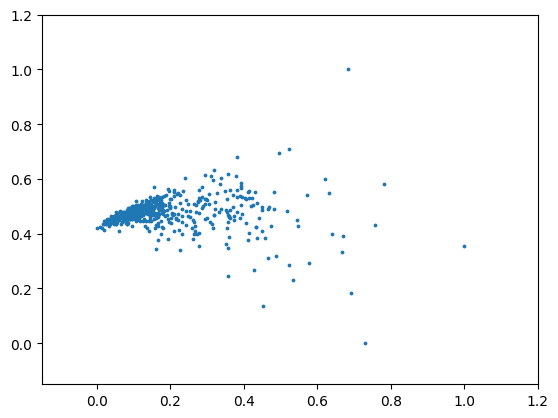

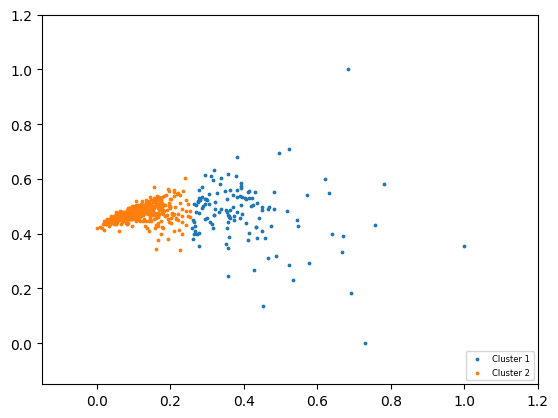

Davies-Bouldin Index: 0.6538803047039581
Silhouette Score: 0.6466957026867074
Execution time:  1.013462781906128


In [65]:
# Set the number of centers (k), dataset model ("bc" in this case), and count1 (used to print Quantum circuit in get_Distance())
k = 2
model = "bc"

# Get the data points using the specified model ("bc")
points = get_data(k, model)

# Preprocess (normalize) the data points using Min-Max scaling
points = preprocess(points)

# Initialize the centroids for the k-means algorithm
centroids = initialize_centers(points, k)

# Plot the initial data points without centers (label=False)
plt.figure()
draw_plot(points, centroids, label=False)

# Run the k-means algorithm for 2 iterations
start_time = time.time()
for i in range(100):
    # Find the nearest centers for each data point using the current centroids
    centers = find_nearest_neighbour(points, centroids)
    
    # Plot the data points with centers after each iteration
    plt.figure()
    draw_plot(points, centers)
    
    # Update the centroids based on the mean of the data points belonging to each cluster
    centroids = find_centroids(points, centers)

end_time = time.time()

# Calculate the Davies-Bouldin Index to evaluate the clustering quality
db_index = davies_bouldin_score(points, centers)
print('Davies-Bouldin Index:', db_index)

# Calculate the Silhouette Score to evaluate the clustering quality
silhoutte_score = silhouette_score(points, centers)
print('Silhouette Score:', silhoutte_score)

# Calculate the execution time of the k-means algorithm in minutes
exec_time = end_time - start_time
print("Execution time: ", exec_time)